## MAKEMORE: becoming a backprop ninja

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # alphabet
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [26]:
block_size = 3

# function to build data set with train/dev/test splits
def build_dataset(words):
    X, Y = [], []  # X is input, Y is label
    for w in words:
        context = [0] * block_size # initialize context by padding with 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X) # X contains indexes of input letters
    Y = torch.tensor(Y) # Y contains indexes of output letters
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()

    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the characeter embedding vectors
n_hidden = 64 # no. of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),                   generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                              generator=g) * 0.1 # using b1 just for fun, it is useless because of batchNorm layer

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.1
b2 = torch.randn(vocab_size,                            generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y


Note on Batch Norm
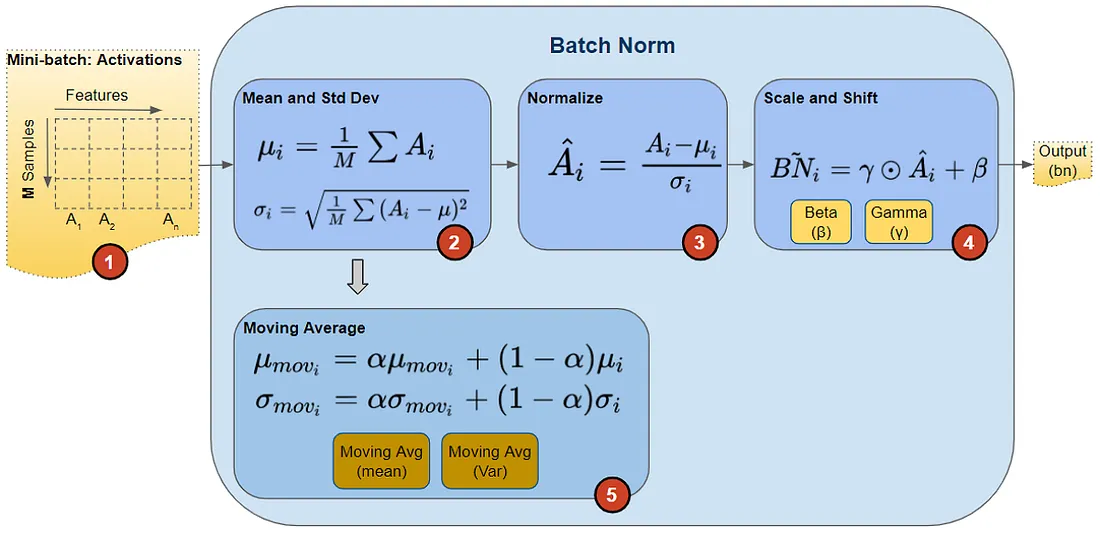

In [8]:
# chunkated into smaller steps that are possible to backward one at a time
# forward pass
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2
# Cross entropy loss (same as F.cross_entropy(logist, Yb))
logit_maxes = logits.max(1, keepdim=True).values # similar to logits * one_hot matrix presenting indices of max values along the row (F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * logits).sum(1, keepdim=True)
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()          # exponential
counts_sum = counts.sum(1, keepdim=True) # sum of exponentials
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # (-logprobs * F.one_hot(Yb, num_classes=vocab_size)).sum(1, keepdim=True).mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None

for t in[logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3243, grad_fn=<NegBackward0>)

## Exercise 1
- Back prop through the whole thing manually

In [9]:
# Back propagation - derivatives should have the same shape as the original

# --- Cross-entropy --- #
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = 1.0/probs * dlogprobs # chain rule
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # sum across columns
dcounts_sum = -1.0 * counts_sum**-2 * dcounts_sum_inv
dcounts = (counts_sum_inv * dprobs) # Branch 1 of counts grad - dcounts = (counts_sum_inv * dprobs)
dcounts += (torch.ones_like(counts) * dcounts_sum) # Branch 2 of counts grad - dcounts = (dcounts_sum)
dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # Alternative answer: torch.zeros_like(dnorm_logits) a.k.a 0, as changeing logit_maxes does not affect loss
dlogits = dnorm_logits.clone() # exact copy as dnorm_logits flows through sum operation
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # one-hot matrix representing indices of max value (along each row) multiply with dlogit_maxes

# --- Linear layer 2 --- #
db2 = dlogits.sum(0) # sum over rows i.e., individual batches
dh = dlogits @ W2.T
dW2 = h.T @ dlogits

# --- Non-linear layer --- #
dhpreact = (1.0 - h**2) * dh

# --- Batch Norm layer --- #
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff *dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar # replication by multiplying with torch.ones_likes(bndiff2)
dbndiff = bnvar_inv*dbnraw
dbndiff += 2*bndiff*dbndiff2
dbnmeani = (-torch.ones_like(bndiff)*dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone() # need to clone to get the copy
dhprebn += 1.0/n*dbnmeani*torch.ones_like(hprebn)
db1 = dhprebn.sum(0, keepdim=True)
dW1 = embcat.T @ dhprebn
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape) # reshape as emb.shape
dC = torch.zeros_like(C)

# Route the gradient demb back to dC. if any rows in C are used more than once, its gradient must be added together
# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k,j]
#         dC[ix] += demb[k,j] # multiple occurrences are to be added
Xb_oh = F.one_hot(Xb, num_classes = 27).float() # Convert the selection operation into a selection matrix, where emb = C[Xb] <-> (Xb_oh @ C).view(n, block_size, n_embd)
dC = (Xb_oh.permute(0,2,1) @ demb).sum(0) # Differentiate like any other matrix operation (dC = Xb_oh.T @ demb; indices to track the batch dimensions)

In [10]:
# Verification
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('b2', db2, b2)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani )
cmp('hprebn', dhprebn, hprebn)
cmp('b1', db1, b1)
cmp('W1', dW1, W1)
cmp('embcat', dembcat, embcat)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

Note:
- if forward pass is replication through broadcasting, backward pass will be summation
- if forward pass is summation, backward pass will involve replication (boardcasting)
- Backward pass of matrix multiplication is matrix multiplication
- Gradient flows through summation without being altered

## Exercise 2
- back prop through the cross-entropy but all in one go by simplifying the expression of the loss `dLoss/dlogits`
- softmax 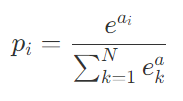
- cross-entroy 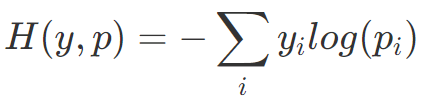

`Answer`:
- Derivative of `softmax` `pi`: 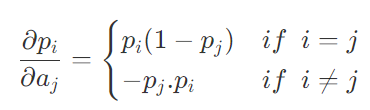
- Derivate of `loss` 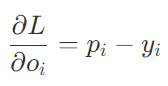 where y is the one-hot encoder of label `Yb`

In [11]:
dlogits = probs.clone()
dlogits[range(n), Yb] -= 1
dlogits /= n # back prop for mean() in loss calculation
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [12]:
dlogits = (((probs-1) * F.one_hot(Yb, num_classes=vocab_size)) + probs - ((probs) * F.one_hot(Yb, num_classes=vocab_size)))
dlogits *= (1/n) # back prop for mean() in loss calculation
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [13]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n # back prop for mean() in loss calculation
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [14]:
dlogits[0]

tensor([ 0.0021,  0.0029,  0.0006,  0.0016,  0.0006,  0.0024,  0.0008,  0.0011,
        -0.0307,  0.0010,  0.0012,  0.0011,  0.0012,  0.0009,  0.0012,  0.0005,
         0.0003,  0.0006,  0.0004,  0.0016,  0.0015,  0.0007,  0.0008,  0.0023,
         0.0019,  0.0009,  0.0007], grad_fn=<SelectBackward0>)

In [15]:
dlogits[0].sum() # very close to 0

tensor(3.9581e-09, grad_fn=<SumBackward0>)

In [16]:
-dlogits[0] * 0.01

tensor([-2.1314e-05, -2.8629e-05, -6.0473e-06, -1.5725e-05, -6.2296e-06,
        -2.4069e-05, -8.1736e-06, -1.0766e-05,  3.0687e-04, -1.0302e-05,
        -1.1688e-05, -1.0770e-05, -1.1927e-05, -9.0297e-06, -1.1983e-05,
        -4.5279e-06, -2.9096e-06, -6.0078e-06, -4.3488e-06, -1.5875e-05,
        -1.4626e-05, -6.9042e-06, -7.6794e-06, -2.2925e-05, -1.9185e-05,
        -8.5037e-06, -6.7205e-06], grad_fn=<MulBackward0>)

Text(0, 0.5, 'batches')

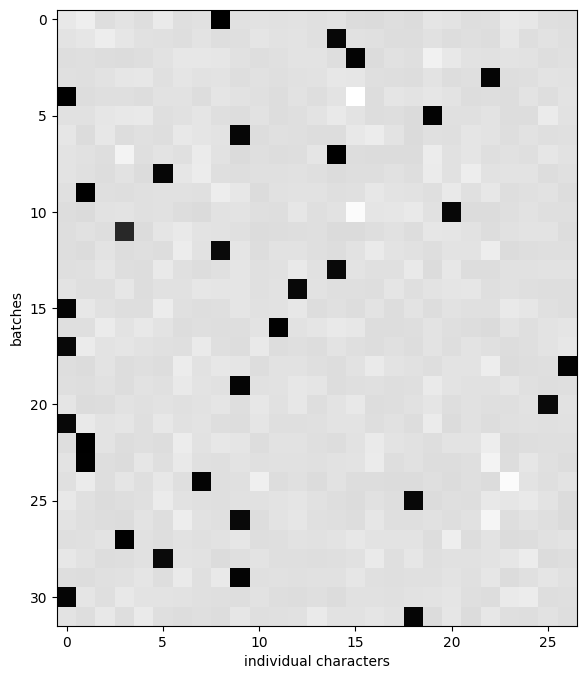

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')
plt.xlabel('individual characters'); plt.ylabel('batches')

## Exercise 3

- Backprop through the batchnorm but all in one go by simplifying the batchnorm's mathematical expression
- Back prop (finding the local gradient) from right to left

`Initial problems`
- check how many arrows going from one variable to another. If multiple arrows are coming out from one variables, each respective gradient (back prop along the arrow) must be summed up

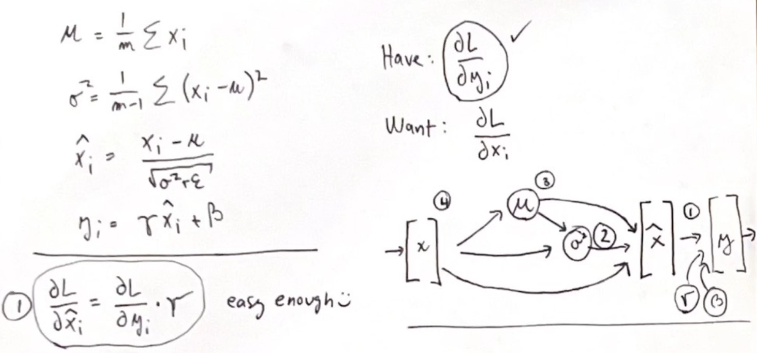

`Expression`

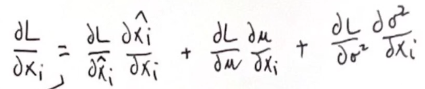

`Answers`
https://youtu.be/q8SA3rM6ckI?si=5sMnJziJu8f-JprS&t=6057

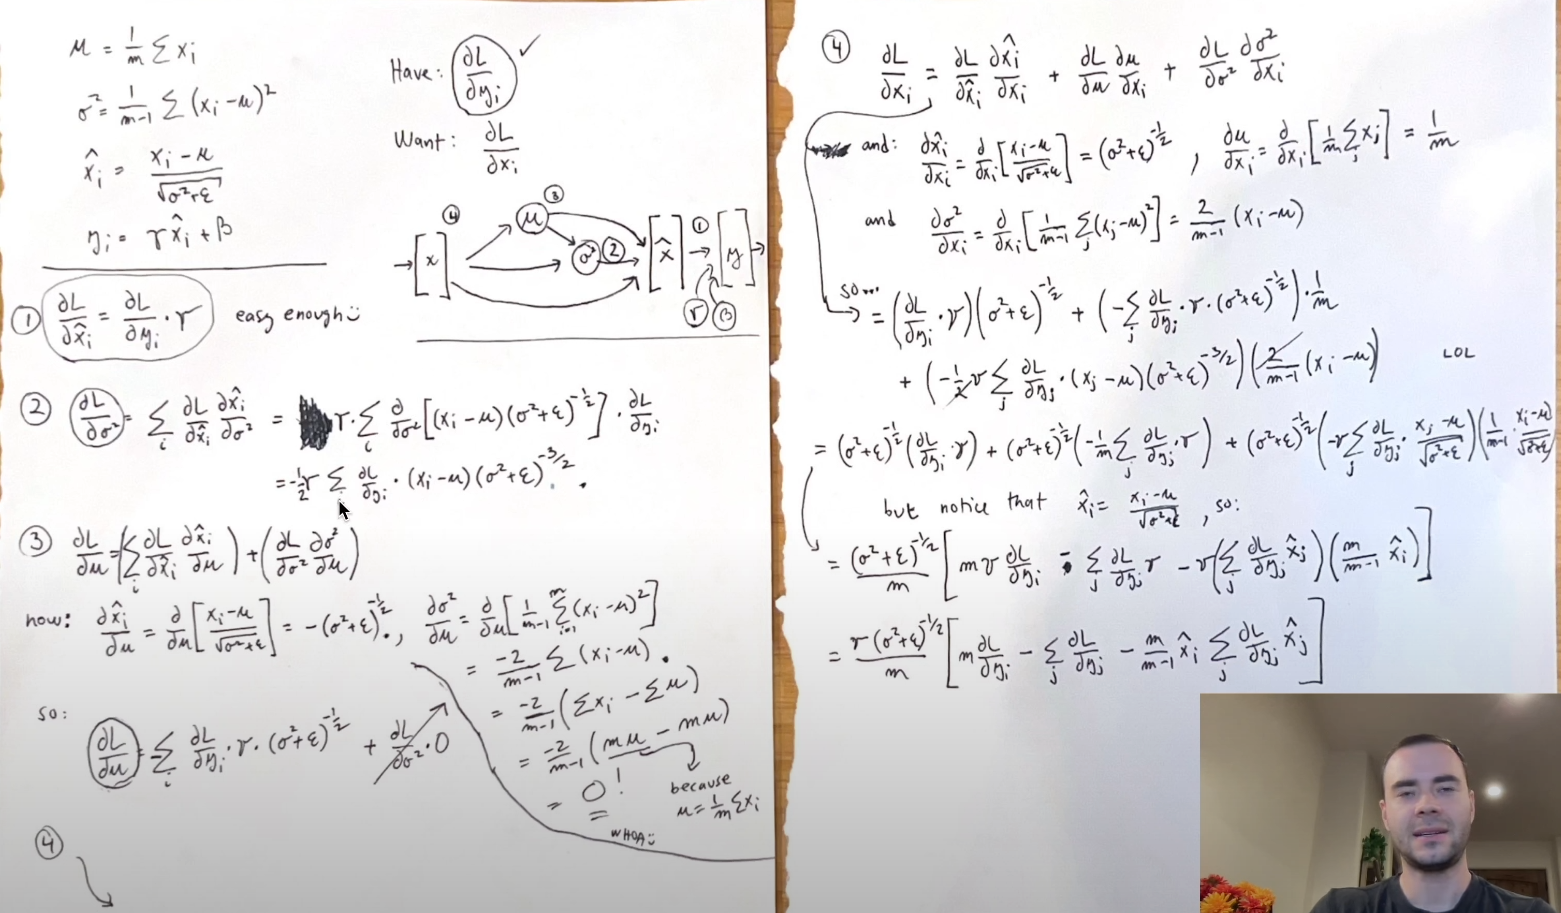

In [20]:
dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [21]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

## Exercise 4
- Put it all together
- Train the MLP neural net with your own backward pass

In [85]:
# init
n_embd = 10 # the dimensionality of the characeter embedding vectors
n_hidden = 200 # no. of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),                   generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                              generator=g) * 0.1 # using b1 just for fun, it is useless because of batchNorm layer

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.1
b2 = torch.randn(vocab_size,                            generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [86]:
# optimization
max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad(): # for manual backprop
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

        # Linear layer 1
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        # Linear layer 2
        logits = h @ W2 + b2
        # Cross entropy loss (same as F.cross_entropy(logist, Yb))
        loss = F.cross_entropy(logits, Yb) # loss function

        # Pytorch backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use for correctness comparisons

        # Manual backprop!
        # ------------------------
        # Cross-entropy #
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n

        # Linear layer 2 #
        db2 = dlogits.sum(0) # sum over rows i.e., individual batches
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits

        # Non-linear layer #
        dhpreact = (1.0 - h**2) * dh

        # Batch Norm layer  #
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))

        # Linear layer 1 #
        db1 = dhprebn.sum(0, keepdim=True)
        dW1 = embcat.T @ dhprebn
        dembcat = dhprebn @ W1.T

        # Embedding layer #
        demb = dembcat.view(emb.shape) # reshape as emb.shape
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j] # multiple occurrences are to be added
        
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias] # parameters = [C, W1, b1, W2, b2, bngain, bnbias]
        # ------------------------
        
        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads): # Stochastic gradient descent
            # p.data += -lr * p.grad
            p.data += -lr * grad[0]

        # track stats
        if i % (max_steps/10) == 0 or i == max_steps-1: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        # if i >= 100:
        #     break

      0/ 200000: 3.6197
  20000/ 200000: 2.8672
  40000/ 200000: 2.6300
  60000/ 200000: 2.4624
  80000/ 200000: 2.7170
 100000/ 200000: 2.8171
 120000/ 200000: 2.6433
 140000/ 200000: 2.8003
 160000/ 200000: 2.7455
 180000/ 200000: 2.5949
 199999/ 200000: 3.0353


In [82]:
# compare the gradients with .backward() - comment when similar
for p, g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 9.778887033462524e-09
(200,)          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [87]:
# Calibrate batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [88]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# put layers into eval mode
split_loss('train')
split_loss('val')

train 2.696014404296875
val 2.696904182434082


In [37]:
# sample from the model
g = torch.Generator().manual_seed(2147473647)

for _ in range(20):
    out = []
    context = [0] * block_size # current context window size = 3
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # shift the context window
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

evaesea.
aikassen.
elli.
jaynn.
jilo.
khaelaie.
braiha.
zayu.
dilyn.
collyangedra.
gabriah.
mavari.
jalim.
li.
mar.
zey.
varhhinn.
zarjanna.
gdeleckaro.
kaleryn.
